In [102]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 1.0.5
numpy version: 1.19.5
seaborn version: 0.11.2


# Transaction Train Data

This is the largest database containing everydat transactions in two years period. There is no missing data in this dataset.

In [103]:
df_transactions = pd.read_csv('/Users/marisatania/Downloads/transactions_train.csv')

Transactions data description:

- **t_dat** :  Date of a transaction in format YYYY-MM-DD but provided as a string.
- **customer_id** : A unique identifier of every customer (mapped to the customer_id in customers table)
- **article_id** : A unique identifier of every article (mapped to the article_id in articles table)
- **price** : Price of purchase
- **sales_channel_id** : sales channel 1 or 2

In [30]:
df_transactions.isna().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

In [4]:
df_transactions

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1


In [50]:
df_transactions.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')

## EDA

In this EDA, we will analize the given transaction data and identify different product and customer behaviours, so they can be used as features while creating different recommendation models.

In [4]:
df_transactions.describe()

,article_id,price,sales_channel_id
count,3.178832e+07,3.178832e+07,3.178832e+07
mean,6.962272e+08,2.782927e-02,1.704028e+00
std,1.334480e+08,1.918113e-02,4.564786e-01
min,1.087750e+08,1.694915e-05,1.000000e+00
25%,6.328030e+08,1.581356e-02,1.000000e+00
50%,7.145820e+08,2.540678e-02,2.000000e+00
75%,7.865240e+08,3.388136e-02,2.000000e+00
max,9.562170e+08,5.915254e-01,2.000000e+00


In [5]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


In [6]:
df_transactions.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [31]:
df_transactions.nunique()

t_dat                   734
customer_id         1362281
article_id           104547
price                  9857
sales_channel_id          2
dtype: int64

***

## Handling The Large Dataset

The transactions_train data has 31788324 non-null data with 1.2+ GB memory usage. We will apply a memory reduction technique by reducing the datatypes where there is un-necessary space. 

Code source: [Chris Deotte]('https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635')

In [34]:
df_transactions.memory_usage(deep=True)

Index                      128
t_dat               2129817708
customer_id         3846387204
article_id           254306592
price                254306592
sales_channel_id     254306592
dtype: int64

This memory trick will reduce the training data memory by 5x, from 96 bytes per row to 20 bytes per row.

The customer_id is a length 64 string which uses 64 bytes. The code below converts the column to int64 which only takes 8 bytes. Also the mapping is 1:1 which means each customer gets a unique int64. After we are done with your processing, i.e. train.groupby('customer_id'), we can merge this onto the sample_submission.csv dataframe.

In [35]:
df_transactions['customer_id'] = (
    df_transactions['customer_id'].apply(lambda x: int(x[-16:], 16)).astype('int64')
)
df_transactions['article_id'] = df_transactions['article_id'].astype('int32')
df_transactions['article_id'] = '0' + df_transactions.article_id.astype('str')

***

## Transactions analysis


### Article ID in Transaction

In [95]:
df_sold_qty = df_transactions.article_id.value_counts()
df_sold_qty

0706016001    50287
0706016002    35043
0372860001    31718
0610776002    30199
0759871002    26329
              ...  
0521266001        1
0548210003        1
0504619001        1
0564231010        1
0796294003        1
Name: article_id, Length: 104547, dtype: int64

In [54]:
df_sold_qty=df_sold_qty.reset_index()
df_sold_qty.rename(columns = {'article_id':'sold_qty','index':'article_id'}, inplace=True)
df_sold_qty.head()

,article_id,sold_qty,sold_qty
0,0,0706016001,50287
1,1,0706016002,35043
2,2,0372860001,31718
3,3,0610776002,30199
4,4,0759871002,26329


In [55]:
df_sold_qty['sold_qty'].describe()

,sold_qty
count,104547.000000
mean,304.057735
std,791.266060
min,1.000000
25%,14.000000
50%,65.000000
75%,286.000000
max,50287.000000


Based on the sold quantities, we can see that:

- There are 105,000 different articles in the transactions.
- There are items which have been sold only once
- 25% of sold products, have been sold 14 or less times
- 50% were sold 65 or less times
- 75% were sold 286 or less times,
- The most sold item have been sold 50,287 times.

### Data Distributiom over time

In [106]:
df_transactions['t_dat'] = pd.to_datetime(df_transactions['t_dat'])

In [12]:
begin = df_transactions['t_dat'].min()
end = df_transactions['t_dat'].max()
print('Date range is from {} to {}.'.format(begin.date(), end.date()))

Date range is from 2018-09-20 to 2020-09-22.


In [13]:
transaction_time = pd.to_datetime(df_transactions['t_dat'])

In [15]:
table = pd.Categorical(transaction_time.dt.year.values.squeeze(),ordered=True).value_counts()
print(pd.DataFrame(table).T)

      2018      2019      2020
0  4411262  16396930  10980132


In [16]:
df_transactions.groupby(by=[df_transactions.t_dat.dt.year , df_transactions.t_dat.dt.month]).agg({'price' : ['min','max','mean','std']})

price                              
                  min       max      mean       std
t_dat t_dat                                        
2018  9      0.000678  0.591525  0.029853  0.023039
      10     0.000678  0.591525  0.029766  0.022821
      11     0.000678  0.591525  0.030694  0.022878
      12     0.000661  0.506780  0.028318  0.021112
2019  1      0.000678  0.506780  0.026475  0.018738
      2      0.000559  0.506780  0.027272  0.017981
      3      0.000542  0.422034  0.029181  0.018941
      4      0.000169  0.506780  0.029005  0.018441
      5      0.000237  0.494441  0.027788  0.017362
      6      0.000051  0.506780  0.025521  0.015543
      7      0.000102  0.422034  0.022344  0.015007
      8      0.000102  0.506780  0.024368  0.018323
      9      0.000017  0.506780  0.032843  0.023798
      10     0.000322  0.506780  0.032254  0.023553
      11     0.000237  0.506780  0.032432  0.023481
      12     0.000186  0.422034  0.027960  0.020273
2020  1      0.000034  0.506780  0.026751  0.017922
      2      0.000186  0.506780  0.028739  0.018844
      3      0.000153  0.506780  0.028894  0.017886
      4      0.000983  0.337288  0.028197  0.015885
      5      0.000203  0.456102  0.027277  0.015979
      6      0.000034  0.501339  0.024401  0.014761
      7      0.000136  0.506780  0.023946  0.015023
      8      0.000322  0.506780  0.026779  0.018287
      9      0.000322  0.506780  0.033577  0.022457

In [17]:
df_transactions.groupby(by=[df_transactions.t_dat.dt.month]).agg({'price' : ['min','max','mean','std']})

price                              
            min       max      mean       std
t_dat                                        
1      0.000034  0.506780  0.026602  0.018368
2      0.000186  0.506780  0.027954  0.018402
3      0.000153  0.506780  0.029053  0.018476
4      0.000169  0.506780  0.028620  0.017276
5      0.000203  0.494441  0.027549  0.016734
6      0.000034  0.506780  0.024983  0.015183
7      0.000102  0.506780  0.023030  0.015035
8      0.000102  0.506780  0.025565  0.018345
9      0.000017  0.591525  0.032388  0.023267
10     0.000322  0.591525  0.030888  0.023187
11     0.000237  0.591525  0.031538  0.023189
12     0.000186  0.506780  0.028141  0.020703

### Purchases per day

In [107]:
t_per_day = df_transactions.groupby('t_dat',as_index=False).count()

In [23]:
t_per_day

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,48399,48399,48399,48399
1,2018-09-21,47543,47543,47543,47543
2,2018-09-22,17635,17635,17635,17635
3,2018-09-23,52230,52230,52230,52230
4,2018-09-24,45984,45984,45984,45984
...,...,...,...,...,...
729,2020-09-18,39284,39284,39284,39284
730,2020-09-19,36796,36796,36796,36796
731,2020-09-20,31489,31489,31489,31489
732,2020-09-21,32130,32130,32130,32130


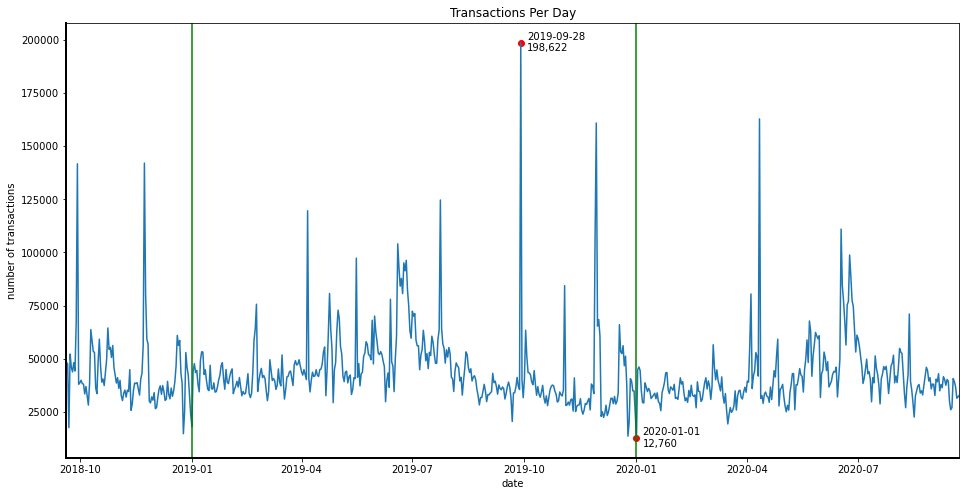

In [108]:
fig, ax = plt.subplots(figsize=(16,8))

sns.lineplot(data=t_per_day, x='t_dat',y='customer_id')

ax.set_xlabel('date')
ax.set_ylabel('number of transactions')

ax.axvline(x=dt.datetime(2019,1,1), c='green')
ax.axvline(x=dt.datetime(2020,1,1), c='green')

max_t = t_per_day['customer_id'].max()
max_t_date = t_per_day[t_per_day['customer_id']==max_t]['t_dat']
ax.scatter(max_t_date, max_t, c='red')
ax.text(max_t_date+pd.DateOffset(days=5), max_t-4000, '{}\n{:,d}'.format(max_t_date.iloc[0].date(), max_t))

min_t = t_per_day['customer_id'].min()
min_t_date = t_per_day[t_per_day['customer_id']==min_t]['t_dat']
ax.scatter(min_t_date, min_t, c='red')
ax.text(min_t_date+pd.DateOffset(days=5), min_t-4000, '{}\n{:,d}'.format(min_t_date.iloc[0].date(), min_t))
ax.set_xlim(df_transactions['t_dat'].min(),df_transactions['t_dat'].max())

for loc in ['bottom', 'left']:
    ax.spines[loc].set_visible(True)
    ax.spines[loc].set_linewidth(2)
    ax.spines[loc].set_color('black')

plt.title('Transactions Per Day')
plt.show()

There are ~8 spikes per year. From the graph above we see that there are distinct variations and spikes in the number of transactions per day. It would be clearer to visualise this by using box plots with monthly aggregations. 

In [109]:
trans_gr_month = df_transactions.groupby('t_dat').size().rename('no_transactions')
trans_gr_month = trans_gr_month.reset_index()
trans_gr_month['month_year'] = trans_gr_month['t_dat'].dt.to_period('M')

In [110]:
trans_gr_month

,t_dat,no_transactions,month_year
0,2018-09-20,48399,2018-09
1,2018-09-21,47543,2018-09
2,2018-09-22,17635,2018-09
3,2018-09-23,52230,2018-09
4,2018-09-24,45984,2018-09
...,...,...,...
729,2020-09-18,39284,2020-09
730,2020-09-19,36796,2020-09
731,2020-09-20,31489,2020-09
732,2020-09-21,32130,2020-09


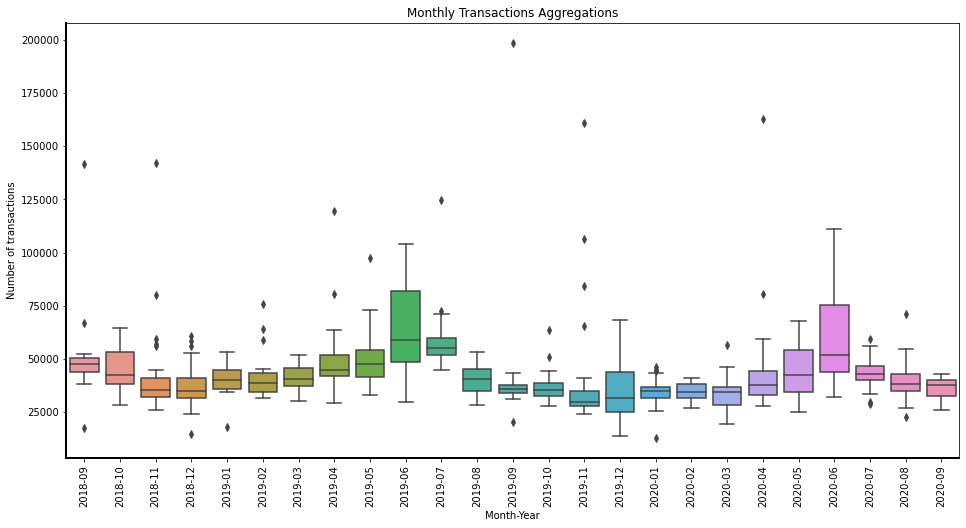

In [111]:
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.boxplot(x='month_year', y='no_transactions', data=trans_gr_month)
plt.xticks(rotation=90)
for loc in ['bottom', 'left']:
    ax.spines[loc].set_visible(True)
    ax.spines[loc].set_linewidth(2)
    ax.spines[loc].set_color('black')
ax.set_xlabel('Month-Year')
ax.set_ylabel('Number of transactions')
plt.title('Monthly Transactions Aggregations')
plt.show()

The bar chart above show us that per day usuall number of transactions lays in range about between 25,000 and 80,000 transactions per day. We see also that sales spikes during summertime and drops during winter.

### Price Column

Code source: [Robert Kwiatkowski]('https://www.kaggle.com/datark1/detailed-eda-understanding-h-m-data')

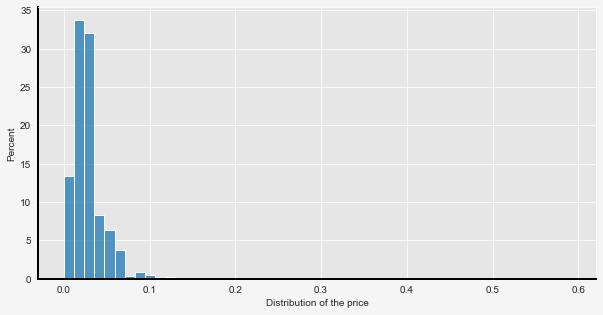

In [14]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(figsize=(10,5), facecolor='#f6f5f5')
ax = sns.histplot(data=df_transactions, x='price', bins=50, stat="percent")
ax.set_xlabel('Distribution of the price')
for loc in ['bottom', 'left']:
    ax.spines[loc].set_visible(True)
    ax.spines[loc].set_linewidth(2)
    ax.spines[loc].set_color('black')
plt.show()

It's clear from the above graph that we have a lot of outliers. Let's look at the price after cutting the values above 0.1.



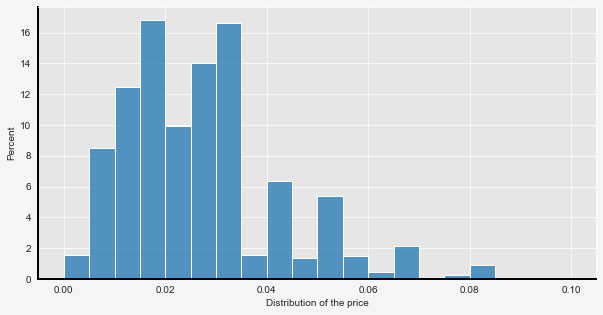

In [16]:
fig, ax = plt.subplots(figsize=(10,5), facecolor='#f6f5f5')
data = df_transactions[df_transactions['price']<0.1]
ax = sns.histplot(data=data, x='price', bins=20, stat="percent")
ax.set_xlabel('Distribution of the price')
for loc in ['bottom', 'left']:
    ax.spines[loc].set_visible(True)
    ax.spines[loc].set_linewidth(2)
    ax.spines[loc].set_color('black')
plt.show()

We can see a normal distribution with long right tail.

### Price Outlier

Outliers for price:

In [50]:
pd.set_option('display.float_format', '{:.4f}'.format)
df_transactions.describe()['price']

count   31788324.0000
mean           0.0278
std            0.0192
min            0.0000
25%            0.0158
50%            0.0254
75%            0.0339
max            0.5915
Name: price, dtype: float64

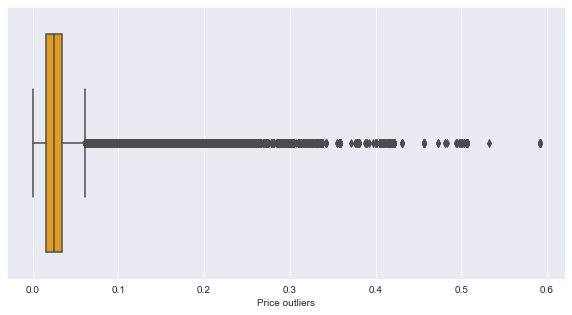

In [51]:
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(10,5))
ax = sns.boxplot(data=df_transactions, x='price', color='orange')
ax.set_xlabel('Price outliers')
plt.show()

From the price outlier, we can see that most of the items are inexpensive with the price below \\$25 dollars and some outliers are super expensive nearly \\$400.

### Customer Spending Habit

Now, let's see how many transactions, on average, customers do.

In [44]:
t_by_customer = df_transactions.groupby('customer_id', as_index=False).size()

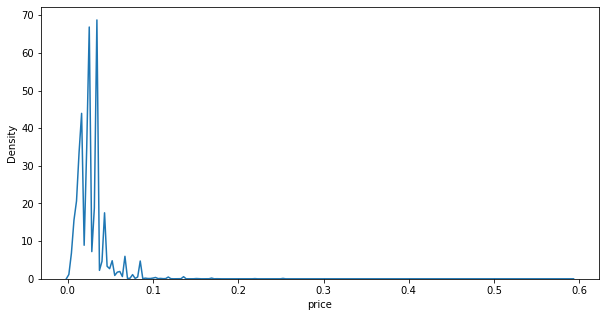

In [112]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(df_transactions.price, ax=ax)

Clearly there's a lot of outliers. Most of sales are for items under $50. In the future, We can use this information to match with the stock from the articles data.

Used code from this [notebook](https://www.kaggle.com/vanguarde/h-m-eda-first-look) By Daniil Karpov

In [113]:
transactions_byid = df_transactions.groupby('customer_id').count()
customer_purchases = transactions_byid.sort_values(by='price', ascending=False)['price']

In [114]:
customer_purchases[:300_000]

customer_id
be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b    1895
b4db5e5259234574edfff958e170fe3a5e13b6f146752ca066abca3c156acc71    1441
49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05b50a4cd88e34d0748f    1364
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    1361
cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed6012e7e5bea016b4d6    1237
                                                                    ... 
b79da987e364d1c4611b65fee2c01224acb8913aa8db7e114cbfcb1432b60778      31
4226f5dfa58e03bfd3d7063c73087a074065ae7bbaf8c3809fe44ff63a97b2a4      31
4c935841d93b7835d24d6ae446359b468d65cc9a5fde4c40a981e8c518734673      31
e712bb7cc833cbdcc35f36045544f4196b751011661aa26ea650f92b8af376a7      31
0dde7d4b6563f5a5d7af38690c87f729c9ce7590bacfe17dfbe2656c88082942      31
Name: price, Length: 300000, dtype: int64

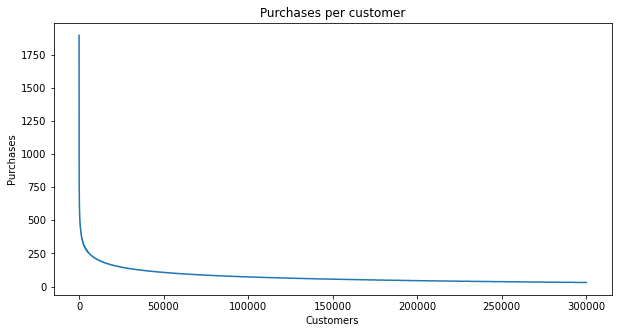

In [116]:
plt.figure(figsize=(10, 5))
plt.plot(list(range(300_000)), customer_purchases[:300_000])
plt.xlabel('Customers')
plt.ylabel('Purchases')
plt.title('Purchases per customer')
plt.show()

We can see a zipf/ negative log distribution.

There are whales who purchased 1000's of items over the years, essentially one item per day over the data set, but that the 300,000 ranked customers in terms of purchases have purchased > 30 items.

In [38]:
total = sum(customer_purchases)
total * 0.8

25430659.200000003

In [39]:
sum(customer_purchases[:419_600])

25430940

In [40]:
round(((419_600 / len(customer_purchases)) * 100), 2)

30.8

31 % of customers account for 80 % of items purchased.

While on average, the rest of the customers only bought a few items during these 2 years.

### Top 10 customers by num of transactions.

In [63]:
transactions_byid = df_transactions.groupby('customer_id').count()

In [64]:
transactions_byid.sort_values(by='price', ascending=False)['price'][:10]

customer_id
 5854009424779598107    1895
 7398229172292340849    1441
 742206143892321423     1364
 3407358910964148684    1361
 1362310019195253974    1237
-4557035136527070563    1208
-4781325834093528838    1170
-6943172096873938826    1169
 1135991499650384534    1157
 8170076110479575893    1143
Name: price, dtype: int64

### Sale Channels

Let's see now the popularity of sale channels.

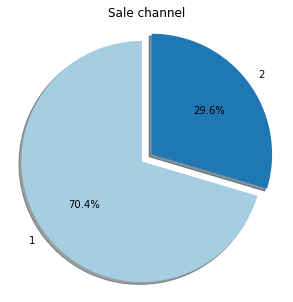

In [100]:
fig, ax = plt.subplots(figsize=(5,5))
explode = (0, 0.1)
colors = sns.color_palette('Paired')
ax.pie(df_transactions['sales_channel_id'].value_counts(), explode=explode, labels=['1','2'],
       autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
ax.axis('equal')
ax.set_title('Sale channel')
plt.show()

We can see that sale channel 1 dominates the sales from 2018 to 2020. Looking at the chart, sale channel 1 is online store and sale channel 2 is brick-a-mortar.

### Scale of the price column

In this [discussion](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/310496) by [tbierhance](https://www.kaggle.com/tbierhance), the author found that the price scaling in the dataset is divided by 590, so we will multiply the price by 590 to get the real price.

In [23]:
temp1 = df_transactions.query("article_id == '0706016001'")[["t_dat", "price"]]
temp2 = df_transactions.query("article_id == '0706016002'")[["t_dat", "price"]]
temp3 = df_transactions.query("article_id == '0372860001'")[["t_dat", "price"]]
temp4 = df_transactions.query("article_id == '0610776002'")[["t_dat", "price"]]

In [24]:
temp1["price"] = temp1["price"] * 590

In [25]:
temp1["price"].value_counts()

19.99    34760
15.99     3510
17.99     3136
16.99      928
14.39      500
         ...  
14.93        1
14.98        1
16.31        1
13.29        1
15.20        1
Name: price, Length: 563, dtype: int64

### Price Discount

Source: [Jake]('https://www.kaggle.com/jakelj/h-m-fashion-comp-eda')

The discounts in 5% increments:

In [27]:
top = 19.99

price_discounts = [round(top - top * (i / 100), 2) for i in list(range(5, 100, 5))]

In [28]:
price_discounts

[18.99,
 17.99,
 16.99,
 15.99,
 14.99,
 13.99,
 12.99,
 11.99,
 10.99,
 9.99,
 9.0,
 8.0,
 7.0,
 6.0,
 5.0,
 4.0,
 3.0,
 2.0,
 1.0]

The banding pattern shows the level of discount:

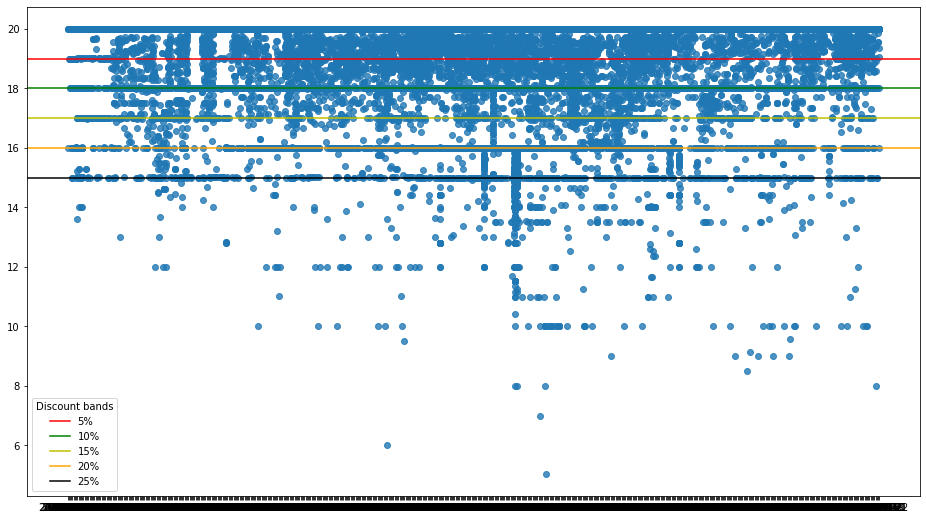

In [29]:
fig, ax = plt.subplots(figsize=(16, 9))
try:
    sns.regplot(x="t_dat", y="price", data=temp1, ax=ax)
except TypeError:
    pass
plt.axhline(y=18.99, color="r", linestyle="-", label="5%")
plt.axhline(y=17.99, color="g", linestyle="-", label="10%")
plt.axhline(y=16.99, color="y", linestyle="-", label="15%")
plt.axhline(y=15.99, color="orange", linestyle="-", label="20%")
plt.axhline(y=14.99, color="black", linestyle="-", label="25%")
plt.legend(title="Discount bands")

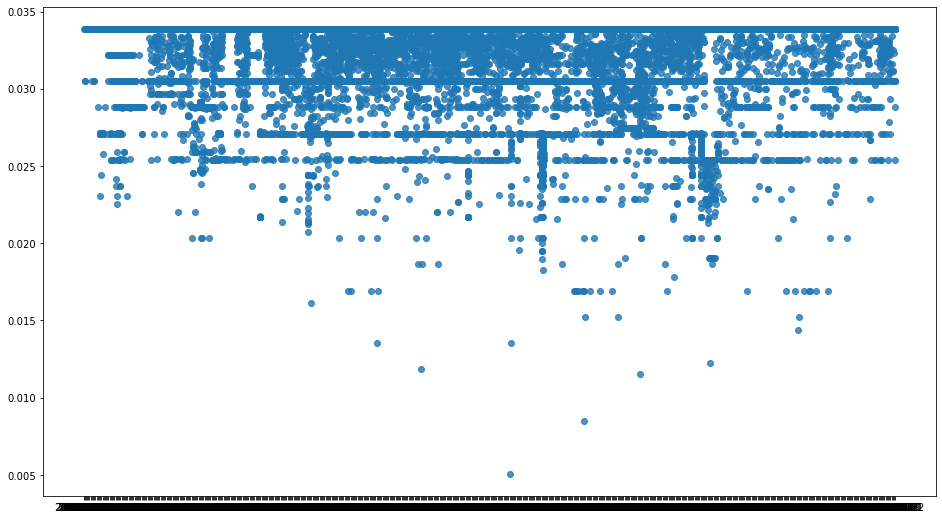

In [31]:
fig, ax = plt.subplots(figsize=(16, 9))
try:
    sns.regplot(x="t_dat", y="price", data=temp2, ax=ax)
except TypeError:
    pass

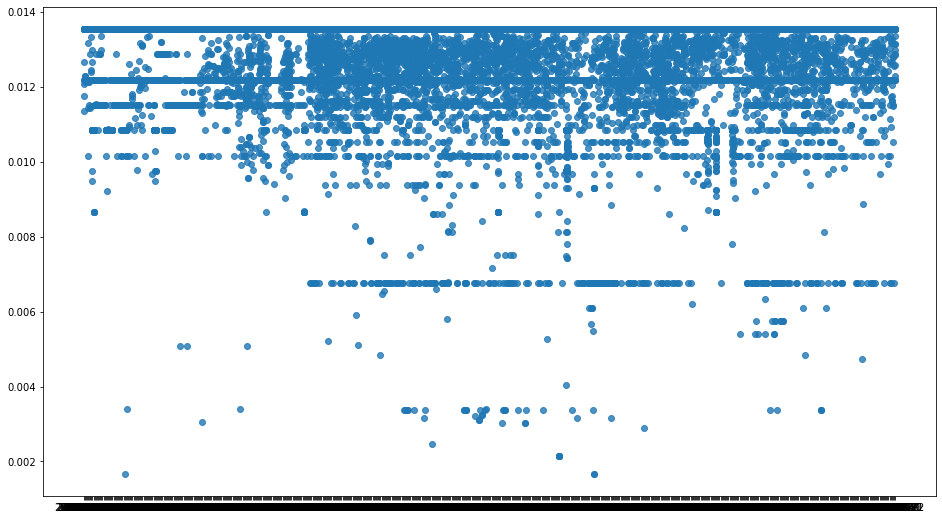

In [32]:
fig, ax = plt.subplots(figsize=(16, 9))
try:
    sns.regplot(x="t_dat", y="price", data=temp3, ax=ax)
except TypeError:
    pass

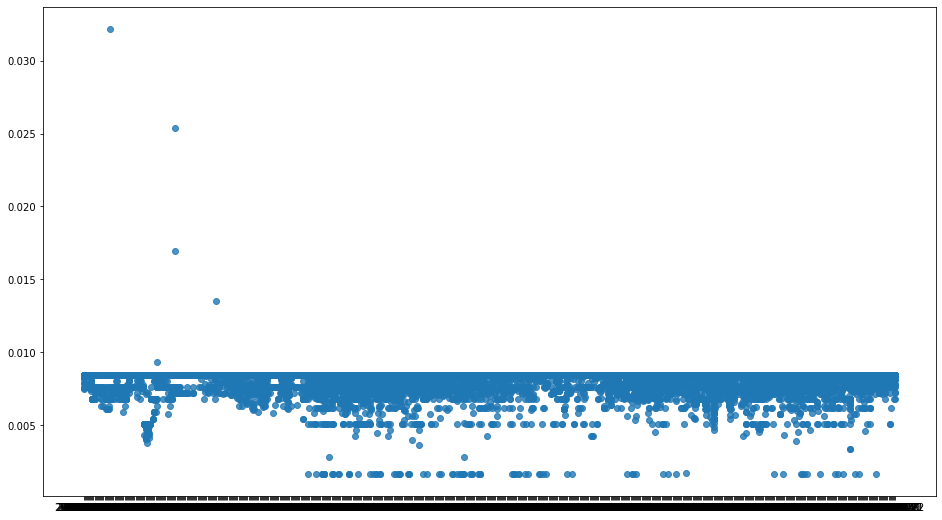

In [33]:
fig, ax = plt.subplots(figsize=(16, 9))
try:
    sns.regplot(x="t_dat", y="price", data=temp4, ax=ax)
except TypeError:
    pass